In [74]:
import glob
import os
import sys
import re
import math
import itertools

import scipy
import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

import spacy
import fasttext
import pkg_resources

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
gloveFile = "glove.6B.50d.txt"

# Our Code

In [75]:
originalPath = "/home/ubuntu/style-transformer/outputs/soph_1/model_iteration_lr_0.0001/"
higherLR = "/home/ubuntu/style-transformer/outputs/soph_1/model_iteration_lr_0.001/"
soph2 = "/home/ubuntu/style-transformer/outputs/soph_2/"
soph3 = "/home/ubuntu/style-transformer/outputs/soph_3/"


In [4]:
def process(sent):
    sent = sent.strip().replace('<pad>', '').strip()
    return sent

In [88]:
def readNaiveTest(runNum):
    path = f"/home/ubuntu/style-transformer/data/soph_{runNum}/test.neg"
    with open(path) as f:
        naive = f.readlines()
    return list(map(process, naive))

In [65]:
def load_transformer(path):
    with open(path + "gold_text.txt") as f:
        gold = f.readlines()
    with open(path + "rev_output_0.txt") as f:
        rev0 = f.readlines()
    with open(path + "raw_output_0.txt") as f:
        raw0 = f.readlines()
    with open(path + "rev_output_1.txt") as f:
        rev1 = f.readlines()
    with open(path + "raw_output_1.txt") as f:
        raw1 = f.readlines()
        
    gold = list(map(process, gold))
    rev0 = list(map(process, rev0))
    raw0 = list(map(process, raw0))
    
    return {0: (gold, rev0, raw0), 1:(gold, rev1, raw1)}

### Bleu

In [10]:
def bleu_sent(originText, transferredText):
    texts_origin = [
        word_tokenize(text.lower().strip()) 
        for text in originText
    ]
    text_transfered = word_tokenize(transferredText.lower().strip())
    cc = SmoothingFunction()
    return sentence_bleu(texts_origin, text_transfered, smoothing_function=cc.method3)



def bleu_avg(originText, transferredText):
    assert len(originText) == len(transferredText), 'Size of inputs does not match!'
    sum = 0
    n = len(originText)
    for x, y in zip(originText, transferredText):
        sum += bleu_sent([x], y)
    return sum / n

In [11]:
bleu_avg(gold, raw0)

0.8358760961477509

### KenLM

LMs add probability to each token sequence to indicate how likely it is for the sequence to occur in real text. Train LM on the target language, and the model estimates the probability of seeing a given sentence in the target text using Markov chains.


In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample. 

The perplexity(sometimes called PP for short) of a language model on a test set is the inverse probability of the test set, normalized by the numberof words. https://lagunita.stanford.edu/c4x/Engineering/CS-224N/asset/slp4.pdf

PPLxdenotes theperplexity of sentences transferred from positive sentences evaluated by a language model trainedwith negative sentences and vice versa. https://arxiv.org/pdf/1805.11749.pdf

In [12]:
def load_kenlm():
    global kenlm
    import kenlm

def train_ngram_lm(kenlm_path, data_path, output_path, N, load=False):
    """
    FROM ARAE
    Trains a modified Kneser-Ney n-gram KenLM from a text file.
    Creates a .arpa file to store n-grams.
    """
    if not load:
        
        curdir = os.path.abspath(os.path.curdir)
        command = "bin/lmplz -o "+str(N)+" <"+os.path.join(curdir, data_path) + \
                  " >"+os.path.join(curdir, output_path)
        print(command)
        os.system("cd "+os.path.join(kenlm_path, 'build')+" && "+command)

    load_kenlm()

    assert(output_path) 
    model = kenlm.Model(output_path)

    return model

In [99]:
kenlm_model = train_ngram_lm('kenlm', 'data/processed/soph_train_3.txt', 'klm_soph_3.arpa', 5, load=True)

bin/lmplz -o 5 </home/ubuntu/CS_230_Project/data/processed/soph_train_3.txt >/home/ubuntu/CS_230_Project/klm_soph_3.arpa


In [45]:

print(kenlm_model.score(gold[0]))
print(kenlm_model.score(rev0[0]))

-11.295788764953613
-13.6751070022583


In [46]:
sentence = gold[10]
# Show scores and n-gram matches
words = ['<s>'] + sentence.split() + ['</s>']
for i, (prob, length, oov) in enumerate(kenlm_model.full_scores(sentence)):
    print('{0} {1}: {2}'.format(prob, length, ' '.join(words[i+2-length:i+2])))
    if oov:
        print('\t"{0}" is an OOV'.format(words[i+1]))

# Find out-of-vocabulary words
for w in words:
    if not w in kenlm_model:
        print('"{0}" is an OOV'.format(w))

-1.716026782989502 2: <s> they
-4.684571266174316 1: follow
-3.069218635559082 1: what
-5.896757125854492 1: technology
	"technology" is an OOV
-1.8870635032653809 1: to
-1.8208752870559692 2: to make
-3.4363248348236084 2: make life
-4.816084384918213 1: .
-0.05439453572034836 2: . </s>
"technology" is an OOV


In [19]:
def get_ppl(lm, sentences):
    """
    Assume sentences is a list of strings (space delimited sentences)
    """
    total_nll = 0
    total_wc = 0
    for sent in sentences:
        words = sent.strip().split()
        nll = np.sum([- math.log(math.pow(10.0, score)) for score, _, _ in lm.full_scores(sent, bos=True, eos=False)])
        word_count = len(words)
        total_wc += word_count
        total_nll += nll
    ppl = np.exp(total_nll / total_wc)
    return ppl

In [20]:
get_ppl(kenlm_model, gold)


720.2415806656699

In [21]:
get_ppl(kenlm_model, raw0)


969.148919193934

In [22]:
get_ppl(kenlm_model, rev0)


1047.93716841179

### Similarities - Jaccard,  Cosine

In [23]:
def jaccard_sim(sent1, sent2): 
    a = set(sent1.split()) 
    b = set(sent2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [24]:
jaccard_sim(gold[0], rev0[0])

0.6

In [31]:

def loadGloveModel(gloveFile):
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    model = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    return model


def cosine_format(raw):

    processed = re.sub("[^a-zA-Z]", " ", raw)
    words = processed.lower().split()
    stopword_set = set(stopwords.words("english"))
    uniq_words = list(set([w for w in words if w not in stopword_set]))
    
    return uniq_words

def cosine_words(word1, word2):

    return (1 - scipy.spatial.distance.cosine(model[word1], model[word2]))


In [26]:
model = loadGloveModel(gloveFile)

In [27]:
def cosine_sent(sent1, sent2):
    if not isinstance(sent1, list):
        sent1 = cosine_format(sent1)
        sent2 = cosine_format(sent2)

    embs1 = np.mean([model[word] for word in sent1], axis=0)
    embs2 = np.mean([model[word] for word in sent2], axis=0)

    return(1 - scipy.spatial.distance.cosine(embs1, embs2))

In [28]:
cosine_sent(gold[106], rev0[106])

0.9578221528266511

In [32]:

def heat_matrix(sent1, sent2):
    
    s1 = cosine_format(sent1)
    s2 = cosine_format(sent2)
    
    result_list = [[cosine_words(word1, word2) for word2 in s2] for word1 in s1]
    result_df = pd.DataFrame(result_list)
    result_df.columns = s2
    result_df.index = s1
    
    return result_df


def heat_map(s1, s2):
    df = heat_matrix(s1, s2)

    fig, ax = plt.subplots(figsize=(5,5)) 
    ax_blue = sns.heatmap(df, cmap="YlGnBu")
    print(cosine_sent(s1, s2))
    return ax_blue

1.0


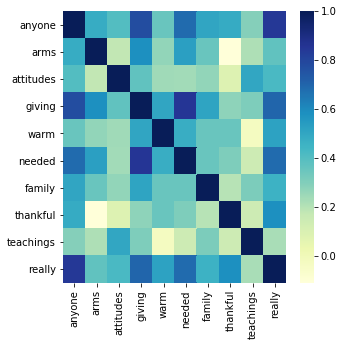

In [33]:
heat_map(gold[105], raw0[105])

### PINC  - https://github.com/cocoxu/Shakespeare/blob/master/python/PINC_sentence.py

In [49]:
from collections import Counter

def intersect(list1, list2) :
    cnt1 = Counter()
    cnt2 = Counter()
    for tk1 in list1:
        cnt1[tk1] += 1
    for tk2 in list2:
        cnt2[tk2] += 1    
    inter = cnt1 & cnt2
    return len(list(inter.elements()))


def pinc(ssent, csent):
    s1grams = ssent.split(" ")
    c1grams = csent.split(" ")
    s2grams = []
    c2grams = []
    s3grams = []
    c3grams = []
    s4grams = []
    c4grams = []
        
    for i in range(0, len(s1grams)-1) :
        if i < len(s1grams) - 1:
            s2gram = s1grams[i] + " " + s1grams[i+1]
            s2grams.append(s2gram)
        if i < len(s1grams)-2:
            s3gram = s1grams[i] + " " + s1grams[i+1] + " " + s1grams[i+2]
            s3grams.append(s3gram)
        if i < len(s1grams)-3:
            s4gram = s1grams[i] + " " + s1grams[i+1] + " " + s1grams[i+2] + " " + s1grams[i+3]
            s4grams.append(s4gram)
            
    for i in range(0, len(c1grams)-1) :
        if i < len(c1grams) - 1:
            c2gram = c1grams[i] + " " + c1grams[i+1]
            c2grams.append(c2gram)
        if i < len(c1grams)-2:
            c3gram = c1grams[i] + " " + c1grams[i+1] + " " + c1grams[i+2]
            c3grams.append(c3gram)
        if i < len(c1grams)-3:
            c4gram = c1grams[i] + " " + c1grams[i+1] + " " + c1grams[i+2] + " " + c1grams[i+3]
            c4grams.append(c4gram)

    score = intersect(s1grams, c1grams) / len(c1grams)
    if len(c2grams) > 0:
        score += intersect(s2grams, c2grams) / len(c2grams)
    if len(c3grams) > 0:
        score += intersect(s3grams, c3grams) / len(c3grams)
    if len(c4grams) > 0:
        score += intersect(s4grams, c4grams) / len(c4grams)
    return 1 - score/4


In [50]:
pinc(gold[106], rev0[106])

0.7291666666666667

In [56]:
def pinc_corpus(origText, transferText):
    sentcount = len(origText)
    pincscore = 0.0

    for idx in range(len(origText)):

        sline = origText[idx].strip()
        cline = transferText[idx].strip()
        
        sentscore = pinc(sline, cline)       
        pincscore += sentscore

    pincscore = pincscore / sentcount * 100
    
    return pincscore

### Putting it all together

In [101]:
def sentenceMetrics(sent1, sent2, kenlm_model, output=False):
    metrics = {}
    
    metrics['bleu'] = bleu_sent(sent1, sent2)
    metrics['cosine'] = cosine_sent(sent1, sent2)
    metrics['jaccard'] = jaccard_sim(sent1, sent2)
    metrics['pinc'] = pinc(sent1, sent2)
    metrics['ppl'] = (get_ppl(kenlm_model, [sent1]), get_ppl(kenlm_model, [sent2]))
    
    if output:
        print(f"Orig: {sent1}")
        print(f"New: {sent2}")
        heat_map(sent1, sent2)
    return metrics

Orig: the mood that the author creates in the memoir is gratefulness.
New: mrs. had brought was appeals in the case is gratefulness.
0.6072675802561083


{'bleu': 0.03747776736677922,
 'cosine': 0.6072675802561083,
 'jaccard': 0.26666666666666666,
 'pinc': 0.8444444444444444,
 'ppl': (462.99934971193403, 717.1712770706305)}

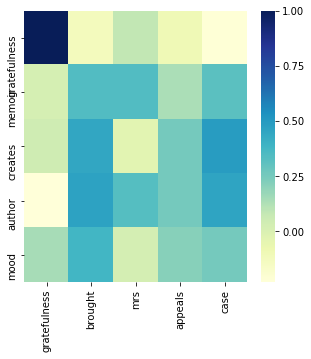

In [55]:
sentenceMetrics(gold[1022], rev0[1022], output=True)

In [102]:
def globalMetrics(origData, transferData, kenlm_model):
    metrics = {}
    
    metrics['bleu'] = bleu_avg(origData, transferData)
    metrics['ppl'] = (get_ppl(kenlm_model, origData), 
                      get_ppl(kenlm_model, transferData))
    metrics['pinc'] = pinc_corpus(origData, transferData)
    
    return metrics

In [58]:
globalMetrics(gold, rev0)

{'bleu': 0.46153848006722215,
 'ppl': (712.1788917124655, 1175.9971924517877),
 'pinc': 51.41437930819486}

### Dataset Metrics

In [70]:
loaded_data = load_transformer(originalPath)
gold_orig, rev_orig, raw_orig = loaded_data[0]

In [71]:
loaded_data = load_transformer(higherLR)
gold_HLR, rev_HLR, raw_HLR = loaded_data[0]

In [72]:
loaded_data = load_transformer(soph2)
gold_soph2, rev_soph2, raw_soph2 = loaded_data[0]

In [91]:
naive_1 = readNaiveTest(1)
naive_2 = readNaiveTest(2)
naive_3 = readNaiveTest(3)

In [100]:
kenlm_1 = train_ngram_lm('kenlm', 'data/processed/soph_train.txt', 'klm_soph_1.arpa', 5, load=True)
kenlm_2 = train_ngram_lm('kenlm', 'data/processed/soph_train_2.txt', 'klm_soph_2.arpa', 5, load=True)
kenlm_3 = train_ngram_lm('kenlm', 'data/processed/soph_train_3.txt', 'klm_soph_3.arpa', 5, load=True)

In [103]:
globalMetrics(naive_1, rev_orig, kenlm_1)

{'bleu': 0.43180909972872106,
 'ppl': (825.2027745964393, 1044.243557723534),
 'pinc': 52.790187889598386}

In [104]:
globalMetrics(naive_1, rev_HLR, kenlm_1)

{'bleu': 0.22843772754951197,
 'ppl': (825.2027745964393, 1638.6271484286542),
 'pinc': 72.99549370336577}

In [105]:
globalMetrics(naive_2, rev_soph2, kenlm_2)

{'bleu': 0.3613066422495174,
 'ppl': (798.1598083846517, 629.9162131290562),
 'pinc': 62.63539704549997}

In [121]:
def SentencePplFrame(reference, transferred, klm):
    ppl_dict = {}
    for i in range(len(reference)):
        ppl_dict[i] = {'ppl':(get_ppl(klm, [reference[i]]), get_ppl(klm, [transferred[i]])), 
                       'sent1': reference[i],
                       'sent2': transferred[i]}
    test_df = pd.DataFrame(ppl_dict).T
    test_df['ppl1'] = test_df.ppl.apply(lambda x: x[0])
    test_df['ppl2'] = test_df.ppl.apply(lambda x: x[1])
    test_df = test_df.sort_values('ppl2')
    cols = ['ppl1', 'ppl2', 'sent1', 'sent2']
    
    return test_df[cols]

In [122]:
df2 = SentencePplFrame(naive_2, rev_soph2, kenlm_2)

In [123]:
df2.head()

,ppl1,ppl2,sent1,sent2
1371,346.059119,23.094756,we are only human.,we are only of the
1354,86.476191,34.806405,there would be no more internet.,there would be no more case of the and the
1602,204.769890,35.481937,he was given to his parents by the scouts.,he was given to his by the and the of the and the
29,204.912192,37.958136,you could go on the internet.,you could go on the case of the and the
1592,9012.109797,42.733628,and when?'.,and of the and


In [124]:
dfOrig = SentencePplFrame(naive_1, rev_orig, kenlm_1)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [125]:
dfOrig

,ppl1,ppl2,sent1,sent2
1264,6.299666e+02,1.219778e+01,i was caught.,i was
870,3.616669e+02,1.450479e+01,it is also very opening.,it was very
1481,1.344034e+02,1.925944e+01,i know i did!,i know i
469,2.006014e+02,2.282417e+01,i live in the .,i live in the
237,9.013228e+03,2.303703e+01,he can’t,he
1367,2.722401e+02,3.699500e+01,what would it be like?,what would it be
827,3.758994e+01,3.758994e+01,this is a good idea for all of us.,this is a good idea for all of us.
555,1.486490e+03,4.250249e+01,have you connect.,have you
604,3.084192e+02,4.613766e+01,he was looking very handsome.,he was looking very
51,1.589690e+02,5.261858e+01,have you ever heard of ?,have you ever heard of her.


# Reference Code from Papers

### Transformer Paper



yelp_acc_path = 'acc_yelp.bin'
yelp_ppl_path = 'ppl_yelp.binary'
yelp_ref0_path = 'yelp.refs.0'
yelp_ref1_path = 'yelp.refs.1'


yelp_acc_file = pkg_resources.resource_stream(resource_package, yelp_acc_path)
yelp_ppl_file = pkg_resources.resource_stream(resource_package, yelp_ppl_path)
yelp_ref0_file = pkg_resources.resource_stream(resource_package, yelp_ref0_path)
yelp_ref1_file = pkg_resources.resource_stream(resource_package, yelp_ref1_path)


self.yelp_ref = []
with open(yelp_ref0_file.name, 'r') as fin:
    self.yelp_ref.append(fin.readlines())
with open(yelp_ref1_file.name, 'r') as fin:
    self.yelp_ref.append(fin.readlines())
self.classifier_yelp = fasttext.load_model(yelp_acc_file.name)
self.yelp_ppl_model = kenlm.Model(yelp_ppl_file.name)

In [ ]:
# Style check from fastText model

def yelp_style_check(self, text_transfered, style_origin):
        text_transfered = ' '.join(word_tokenize(text_transfered.lower().strip()))
        if text_transfered == '':
            return False
        label = self.classifier_yelp.predict([text_transfered])
        style_transfered = label[0][0] == '__label__positive'
        return (style_transfered != style_origin)
    
# Checking the accuracy for different styles
    
def yelp_acc_b(self, texts, styles_origin):
        assert len(texts) == len(styles_origin), 'Size of inputs does not match!'
        count = 0
        for text, style in zip(texts, styles_origin):
            if self.yelp_style_check(text, style):
                count += 1
        return count / len(texts)

def yelp_acc_0(self, texts):
        styles_origin = [0] * len(texts)
        return self.yelp_acc_b(texts, styles_origin)

def yelp_acc_1(self, texts):
        styles_origin = [1] * len(texts)
        return self.yelp_acc_b(texts, styles_origin)

In [40]:
# Initialize the NLTK model
def nltk_bleu(texts_origin, text_transfered):
        texts_origin = [word_tokenize(text_origin.lower().strip()) for text_origin in texts_origin]
        text_transfered = word_tokenize(text_transfered.lower().strip())
        return sentence_bleu(texts_origin, text_transfered) * 100

# Check the BLEU diff between original & transferred text
def self_bleu_b(self, texts_origin, texts_transfered):
        assert len(texts_origin) == len(texts_transfered), 'Size of inputs does not match!'
        sum = 0
        n = len(texts_origin)
        for x, y in zip(texts_origin, texts_transfered):
            sum += self.nltk_bleu([x], y)
        return sum / n

In [ ]:
# Measures perplexity of language model

def yelp_ppl(self, texts_transfered):
        texts_transfered = [' '.join(word_tokenize(itm.lower().strip())) for itm in texts_transfered]
        sum = 0
        words = []
        length = 0
        for i, line in enumerate(texts_transfered):
            words += [word for word in line.split()]
            length += len(line.split())
            score = self.yelp_ppl_model.score(line)
            sum += score
        return math.pow(10, -sum / length)

### ARAE

In [ ]:

def train_ngram_lm(kenlm_path, data_path, output_path, N):
    """
    Trains a modified Kneser-Ney n-gram KenLM from a text file.
    Creates a .arpa file to store n-grams.
    """
    # create .arpa file of n-grams
    curdir = os.path.abspath(os.path.curdir)
    #
    command = "bin/lmplz -o "+str(N)+" <"+os.path.join(curdir, data_path) + \
              " >"+os.path.join(curdir, output_path)
    os.system("cd "+os.path.join(kenlm_path, 'build')+" && "+command)

    load_kenlm()
    # create language model
    assert(output_path)  # captured by try..except block outside
    model = kenlm.Model(output_path)

    return model


def get_ppl(lm, sentences):
    """
    Assume sentences is a list of strings (space delimited sentences)
    """
    total_nll = 0
    total_wc = 0
    for sent in sentences:
        words = sent.strip().split()
        nll = np.sum([- math.log(math.pow(10.0, score)) for score, _, _ in lm.full_scores(sent, bos=True, eos=False)])
        word_count = len(words)
        total_wc += word_count
        total_nll += nll
    ppl = np.exp(total_nll / total_wc)
    return ppl


### Other - https://github.com/adsieg/text_similarity/blob/master/Different%20Embeddings%20%2B%20Cosine%20Similarity%20%2B%20HeatMap%20illustration.ipynb

In [3]:
def cosine_distance_countvectorizer_method(s1, s2):
    
    # sentences to list
    allsentences = [s1 , s2]
    
    # packages
    from sklearn.feature_extraction.text import CountVectorizer
    from scipy.spatial import distance
    
    # text to vector
    vectorizer = CountVectorizer()
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)
    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].tolist()
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].tolist()
    
    # distance of similarity
    cosine = distance.cosine(text_to_vector_v1, text_to_vector_v2)
    print('Similarity of two sentences are equal to ',round((1-cosine)*100,2),'%')
    return cosine

In [4]:


def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    model = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model


def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_words = list(set([w for w in words if w not in stopword_set]))

    return cleaned_words

def cosine_distance_between_two_words(word1, word2):
    import scipy
    return (1- scipy.spatial.distance.cosine(model[word1], model[word2]))

def calculate_heat_matrix_for_two_sentences(s1,s2):
    s1 = preprocess(s1)
    s2 = preprocess(s2)
    result_list = [[cosine_distance_between_two_words(word1, word2) for word2 in s2] for word1 in s1]
    result_df = pd.DataFrame(result_list)
    result_df.columns = s2
    result_df.index = s1
    return result_df

def cosine_distance_wordembedding_method(s1, s2):
    import scipy
    vector_1 = np.mean([model[word] for word in preprocess(s1)],axis=0)
    vector_2 = np.mean([model[word] for word in preprocess(s2)],axis=0)
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    print('Word Embedding method with a cosine distance asses that our two sentences are similar to',round((1-cosine)*100,2),'%')

def heat_map_matrix_between_two_sentences(s1,s2):
    df = calculate_heat_matrix_for_two_sentences(s1,s2)
    import seaborn as sns
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(5,5)) 
    ax_blue = sns.heatmap(df, cmap="YlGnBu")
    # ax_red = sns.heatmap(df)
    print(cosine_distance_wordembedding_method(s1, s2))
    return ax_blue

Word Embedding method with a cosine distance asses that our two sentences are similar to 98.39 %
None


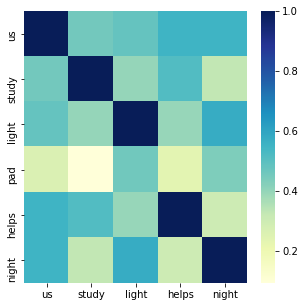

In [13]:
heat_map_matrix_between_two_sentences(gold[100],raw0[100])